In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision.models as models

# 使わない場合は省く
import slack_notification as sn

In [2]:
%matplotlib inline

# Preprocessing

In [3]:
masks  =  pd.read_csv ('./train_ship_segmentations.csv')
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [4]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
"""
ランレングス記法のデータを白黒画像に直す
"""
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    #nan check
    if mask_rle != mask_rle:
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        return img.reshape(shape).T
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [5]:
"""
trainの画像の教師画像を作る
"""
def create_mask(image_path):
    img_masks = masks.loc[masks['ImageId'] == image_path.split('/')[-1], 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    masks_all = np.zeros((768, 768))
    for mask in img_masks:
        masks_all += rle_decode(mask)
    masks_all = np.minimum(masks_all, 1)
    
    return masks_all

In [6]:
"""
白黒画像をランレングス記法にする
"""
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [7]:
def convert_runlength(convert_image):
    convert_image = cv2.resize(convert_image, (768, 768))
    flatten = np.where((convert_image.T).flatten() == 1)[0]
    runlength = ""
    count = 0
    if len(flatten) == 1:
        runlength = str(flatten[0]) + " 1"
        return runlength
    for i in range(len(flatten)):
        if i == 0:
            runlength = runlength +  str(flatten[i]) + " "
            count = 1
        elif i == len(flatten)-1:
            if flatten[i] == flatten[i-1]+1:
                count += 1
                runlength = runlength + str(count)
            else:
                runlength = runlength + str(count) + " " + str(flatten[i]) + " 1"
        else:
            if flatten[i] == flatten[i-1]+1:
                count += 1
            else:
                runlength = runlength + str(count) + " " + str(flatten[i]) + " "
                count = 1
    return runlength

## demo

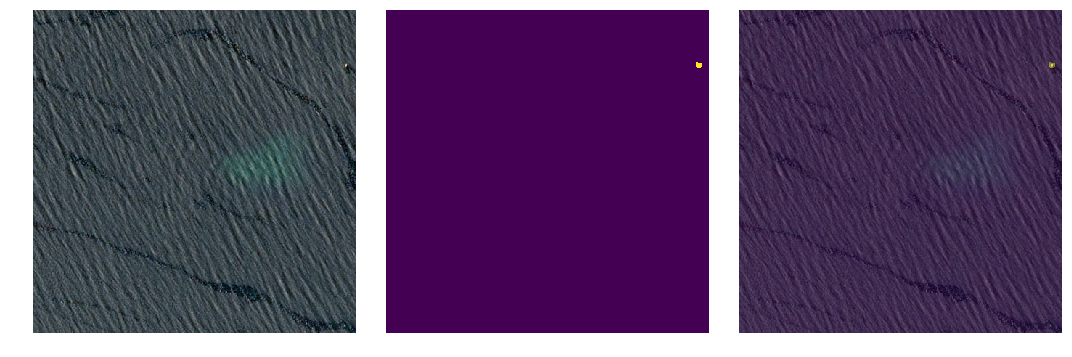

In [8]:
ImageId = '00053c6ba.jpg'

img = cv2.imread('./train/' + ImageId)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)
    
all_masks = np.minimum(all_masks, 1)
fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()


# Make Dataset

In [9]:
#バッチサイズ16より大きいと、メモリが足りなくなる
batch_size = 16
img_size = 256

In [10]:
"""
train用のデータセット
"""
class AirbusDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.image_paths[idx])
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_size, img_size))
        image = image.astype(np.float32)
        image = image/255.0
        masked_img = create_mask(image_path)
        masked_img = cv2.resize(masked_img, (img_size, img_size))
        masked_img = masked_img[:, :, np.newaxis]
        masked_img = masked_img.astype(np.float32)
        if self.transform:
            image = self.transform(image)
            masked_img = self.transform(masked_img)
        return image, masked_img

In [11]:
#pytorch 0.4.1以上に必要
class Resize(object):
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img):
        old_size = img.size  # old_size[0] is in (width, height) format

        ratio = float(self.size)/max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])

        return img.resize(new_size, resample=self.interpolation)
    
#pytorchのgithubより
class ToTensor(object):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """

    def __call__(self, pic):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        return to_tensor(pic)

    def __repr__(self):
        return self.__class__.__name__ + '()'

def to_tensor(pic):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    See ``ToTensor`` for more details.
    Args:
        pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
    Returns:
        Tensor: Converted image.
    """

    if isinstance(pic, np.ndarray):
        # handle numpy array
        img = torch.from_numpy(pic.transpose((2, 0, 1)))
        #ここがダメ、uint8かfloatかで255でわるかどうかを決めてる
        if isinstance(img, torch.ByteTensor):
            #return img.float().div(255)
            return img.float()
        else:
            return img

    if accimage is not None and isinstance(pic, accimage.Image):
        nppic = np.zeros([pic.channels, pic.height, pic.width], dtype=np.float32)
        pic.copyto(nppic)
        return torch.from_numpy(nppic)

    # handle PIL Image
    if pic.mode == 'I':
        img = torch.from_numpy(np.array(pic, np.int32, copy=False))
    elif pic.mode == 'I;16':
        img = torch.from_numpy(np.array(pic, np.int16, copy=False))
    elif pic.mode == 'F':
        img = torch.from_numpy(np.array(pic, np.float32, copy=False))
    elif pic.mode == '1':
        img = 255 * torch.from_numpy(np.array(pic, np.uint8, copy=False))
    else:
        img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
    # PIL image mode: L, P, I, F, RGB, YCbCr, RGBA, CMYK
    if pic.mode == 'YCbCr':
        nchannel = 3
    elif pic.mode == 'I;16':
        nchannel = 1
    else:
        nchannel = len(pic.mode)
    img = img.view(pic.size[1], pic.size[0], nchannel)
    # put it from HWC to CHW format
    # yikes, this transpose takes 80% of the loading time/CPU
    img = img.transpose(0, 1).transpose(0, 2).contiguous()
    if isinstance(img, torch.ByteTensor):
        return img.float().div(255)
    else:
        return img

In [12]:
train_dataset = AirbusDataset(root_dir='./train/', transform=transforms.Compose([
                                            #transforms.ToPILImage(),
                                            #transforms.Resize(size=img_size),
                                            #Resize(size=img_size),
                                            ToTensor(),
                                            ]))
train_batch = data.DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2)

# Make Network

In [13]:
def conv_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model


def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1,output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model


def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool


def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model    


def conv_block_3(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        conv_block(out_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

def conv_block_4(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=1, stride=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

def conv_trans_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def up(in_dim, act_fn):
    model = nn.Sequential(
        act_fn,
        nn.BatchNorm2d(in_dim),
    )
    return model

In [14]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        #self.hook_fnがmのforwardの後に常に呼ばれつるようにする
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        #hookでfeaturesに実行結果を保存しておく
        self.features = output
    def remove(self): 
        #hookを削除
        self.hook.remove()

In [15]:
class Unet34(nn.Module):

	def __init__(self,in_dim=3,out_dim=3,num_filter=64):
		super(Unet34,self).__init__()
		self.in_dim = in_dim
		self.out_dim = out_dim
		self.num_filter = num_filter
		act_fn = nn.LeakyReLU(0.2, inplace=False)
		self.act_fn = act_fn
		print("\n------Initiating U-Net34------\n")
        
		resnet = models.resnet34(pretrained=True)
		resnet = nn.Sequential(*list(resnet.children())[:-2])
		resnet = resnet.float().cuda()

		self.rn = resnet
		self.sfs = [SaveFeatures(resnet[i]) for i in [2, 4,5,6]]

		self.up = up(self.num_filter*4, act_fn)
        
		self.trans_1 = conv_trans_block_2(self.num_filter*8,self.num_filter*2,act_fn)
		self.conv_1 = conv_block_4(self.num_filter*4, self.num_filter*2, act_fn)
		self.trans_2 = conv_trans_block_2(self.num_filter*4,self.num_filter*2,act_fn)
		self.conv_2 = conv_block_4(self.num_filter*2, self.num_filter*2, act_fn)        
		self.trans_3 = conv_trans_block_2(self.num_filter*4,self.num_filter*2,act_fn)
		self.conv_3 = conv_block_4(self.num_filter, self.num_filter*2, act_fn)
		self.trans_4 = conv_trans_block_2(self.num_filter*4,self.num_filter*2,act_fn)
		self.conv_4 = conv_block_4(self.num_filter, self.num_filter*2, act_fn)
        
		self.out = nn.Sequential(
			nn.ConvTranspose2d(256, 1, 2, stride=2),
			nn.Tanh(),
		)

	def forward(self,input):
		x = self.act_fn(self.rn(input))
        
		trans_1 = self.trans_1(x)
		conv_sfs_3 = self.conv_1(self.sfs[3].features)
		concat_1 = torch.cat([trans_1,conv_sfs_3],dim=1)
		up_1 = self.up(concat_1)
        
		trans_2 = self.trans_2(up_1)
		conv_sfs_2 = self.conv_2(self.sfs[2].features)
		concat_2 = torch.cat([trans_2,conv_sfs_2],dim=1)
		up_2 = self.up(concat_2)
        
		trans_3 = self.trans_3(up_2)
		conv_sfs_1 = self.conv_3(self.sfs[1].features)
		concat_3 = torch.cat([trans_3,conv_sfs_1],dim=1)
		up_3 = self.up(concat_3)
        
		trans_4 = self.trans_4(up_3)
		conv_sfs_0 = self.conv_3(self.sfs[0].features)
		concat_4 = torch.cat([trans_4, conv_sfs_0],dim=1)
		up_4 = self.up(concat_4)
		out = self.out(up_4)
		#out = out[:,0]
		return out
    
		def close(self):
			for sf in self.sfs: 
				sf.remove()

In [16]:
def iou(img_true, img_pred):
    #img_true = img_true.transpose(0,2).transpose(0,1)
    #img_pred = img_pred.transpose(0,2).transpose(0,1)
    #img_true = img_true.mean(dim=2)
    #img_pred = img_pred.mean(dim=2)
    i = torch.sum((img_true*img_pred) >0)
    u = torch.sum((img_true + img_pred) >0) + 0.0000001  # avoid division by zero
    return i/u

class IouLoss(nn.Module):
    def __init__(self):
        super(IouLoss, self).__init__()  
    
    def forward(self, input, target):
        _sum = torch.sum(torch.Tensor([iou(target[i], input[i]) for i in range(batch_size)]))/batch_size
        return Variable(torch.FloatTensor(np.array([_sum])), requires_grad=True)

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        #print("focal loss: {}".format(loss.mean()))
        return loss.mean()

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        dice = dice_loss(input, target)
        focalloss = self.alpha*self.focal(input, target)
        #print("dice loss: {}".format(dice))
        loss = focalloss - torch.log(dice)
        #print("mixed loss: {}".format(loss))
        return loss.mean(), dice.item(), focalloss.item()

def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    #print("iflat: {}".format(iflat.sum()))
    #print("tflat: {}".format(tflat.sum()))
    if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
    intersection = (iflat * tflat).sum()
    #print("intersection: {}".format(intersection))
    result = ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
    #print("result: {}".format(result))
    if result <= 0:
        print("dice {} <= 0 ".format(result))
        return torch.Tensor([1])
    return result

In [18]:
#空のモデルから学習する時
#recon_loss_func = nn.MSELoss()
recon_loss_func = MixedLoss(10.0, 2.0)
#generator = nn.DataParallel(Unet34(3,3,64),device_ids=[0]).cuda()
generator = Unet34(3,3,64).cuda()
lr = 0.0001
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
gen_optimizer = torch.optim.SGD(generator.rn.parameters(), momentum=0.9, weight_decay=0.0001, lr=lr*0.1)


------Initiating U-Net34------



# Training

In [19]:
def reform_tensor(tensor):
    tensor = torch.cat([tensor, tensor, tensor], dim=1)
    return tensor

In [20]:
def train(epoch, save_folder_name):
    losses = []
    focallosses = []
    dicelosses = []
    if not os.path.exists("result_{}".format(save_folder_name)):
        os.mkdir("result_{}".format(save_folder_name))
    else:
        print("[warning]: file exist")
    if not os.path.exists("model_{}".format(save_folder_name)):
        os.mkdir("model_{}".format(save_folder_name))
    else:
        print("[warning]: file exist")
    for i in range(epoch):
        for batch_idx, (images,img_masks) in enumerate(train_batch):
            gen_optimizer.zero_grad()

            x = Variable(images).cuda(0).float()
            y_ = Variable(img_masks).cuda(0).float()
            y = generator.forward(x)
            loss, focalloss, diceloss = recon_loss_func(y.cpu(), y_.cpu())
            #print(loss.item())
            loss.backward()
            gen_optimizer.step()
            losses.append(loss.item())
            focallosses.append(focalloss)
            dicelosses.append(diceloss)

            if batch_idx % 400 ==0:
            
                if batch_idx > 0:
                    loss_mean = np.mean(np.array(losses[-30:]))
                else:
                    loss_mean = loss.item()
                print("====== epoch: {}, batch_idx: {}, loss_mean: {} =======".format(i, batch_idx, loss_mean))
                losses_np = np.asarray(losses)
                focallosses_np = np.asarray(focallosses)
                dicelosses_np = np.asarray(dicelosses)
            
                batches = np.array([i for i in range(len(losses_np))])
                plt.figure()
                if batch_idx > 0:
                    plt.ylim(0, np.max(np.array(losses[-30:]))*3)
                plt.plot(batches, losses_np, label="loss")
                plt.plot(batches, focallosses_np, label="focal_loss")
                plt.plot(batches, dicelosses_np, label="dice_loss")
                plt.legend()
                plt.ylabel("loss")
                plt.xlabel("batch")
                plt.savefig('./model_{}/loss.png'.format(save_folder_name))
            
                v_utils.save_image(x.cpu().data,"./result_{}/original_image_{}_{}.png".format(save_folder_name, i, batch_idx))
                v_utils.save_image(reform_tensor(y_.cpu().data), './result_{}/label_image_{}_{}.png'.format(save_folder_name, i, batch_idx))
                v_utils.save_image(reform_tensor(y.cpu().data),"./result_{}/gen_image_{}_{}.png".format(save_folder_name,i, batch_idx))
            
                sn.upload_image(image='./model_{}/loss.png'.format(save_folder_name))
                sn.send_notification(text='finish: epoch {}, batch_idx {}, loss_mean: {}'.format(i, batch_idx, loss_mean))
                
            if batch_idx % 2000 ==0:
                torch.save(generator.state_dict(), './model_{}/unet_{}_{}_state.pkl'.format(save_folder_name, i, batch_idx))

[warning]: file exist
[warning]: file exist
====== epoch: 0, batch_idx: 0, loss_mean: 7.544347763061523 =======
====== epoch: 0, batch_idx: 400, loss_mean: 7.782047398885092 =======
====== epoch: 0, batch_idx: 800, loss_mean: 8.386604388554892 =======


Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
 

KeyboardInterrupt: 

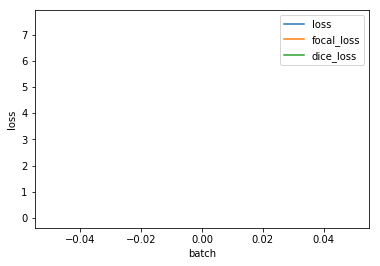

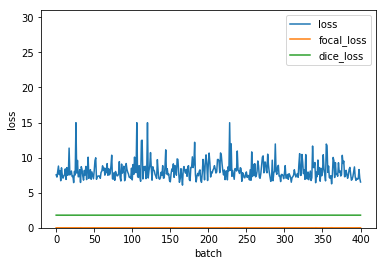

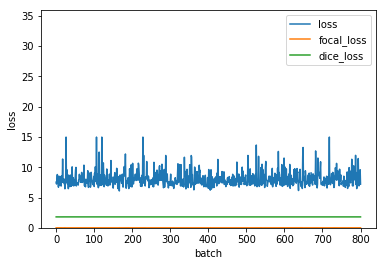

In [21]:
for param in generator.rn.parameters():
    param.requires_grad = False
train(1, 'unet34_0929_pre')
sn.send_notification(text='finish 1 epoch')
for param in generator.rn.parameters():
    param.requires_grad = True
train(10, 'unet34_0929')

# evaluation

In [24]:
"""
test用データセット
"""
class AirbusTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.image_paths[idx])
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_size, img_size))
        image = image.astype(np.float32)
        image = image/255.0
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]

In [25]:
test_dataset = AirbusTestDataset(root_dir='./test/', transform=transforms.Compose([
                                            ToTensor()
                                            ]))
test_batch = data.DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2)

In [26]:
model = nn.DataParallel(Unet34(3,3,64),device_ids=[0]).cuda()


------Initiating U-Net34------



In [27]:
model.load_state_dict(torch.load("./model_unet34/unet_7_4000_state.pkl"))

In [25]:
"""
test_batchの中の最初の画像でテスト
"""
def test_sample(th=0.5):
    count = 0
    for _, (image, image_paths) in enumerate(test_batch):
        if count >= 1:
            break
        count += 1
        image = Variable(image)
        outputs = (model(image).data).cpu().numpy()
        out_img = outputs[0].transpose(1,2,0)
        out_img = np.maximum(out_img, 0)
        out_img = np.minimum(out_img, 1)
        out_gray = np.mean(out_img, axis=2)
        
        max_pixel = 1
        _, out_thresh = cv2.threshold(out_gray, th, max_pixel, cv2.THRESH_BINARY)
        
        out_thresh = cv2.resize(out_thresh, (768, 768))
        rl = rle_encode(out_thresh)
        decoded_img = rle_decode(rl)
        print(np.max(out_gray))
        print(rl)
        
        
        original_img = cv2.imread('./test/{}'.format(image_paths[0]))
        fig, axarr = plt.subplots(1, 4, figsize=(15, 40))
        plt.gray()
        axarr[0].imshow(out_gray)
        axarr[1].imshow(out_thresh)
        axarr[2].imshow(original_img)
        plt.gray()
        axarr[3].imshow(decoded_img)
        plt.tight_layout(h_pad=0.1, w_pad=0.1)
        plt.show()

めんどいから直してないけどtest_sample2のみ動く

In [28]:
"""
test_batchの中で、モデルを通して白い部分が現れるものが出てくるまで繰り返す
"""
def test_sample2(th=0.5):
    for _, (image, image_paths) in enumerate(test_batch):
        image = Variable(image)
        outputs = (model(image).data).cpu().numpy()
        for out_img, image_path in zip(outputs[:,0], image_paths):
            print(out_img.shape)
            out_img = np.maximum(out_img, 0)
            out_img = np.minimum(out_img, 1)
        
            max_pixel = 1
            _, out_thresh = cv2.threshold(out_img, th, max_pixel, cv2.THRESH_BINARY)
        
            out_thresh = cv2.resize(out_thresh, (768, 768))
            #rl = rle_encode(out_thresh)
            rl = convert_runlength(out_thresh)
            if rl != "":
                decoded_img = rle_decode(rl)
                print("max: {}".format(np.max(out_img)))
        
                original_img = cv2.imread('./test/{}'.format(image_path))
                fig, axarr = plt.subplots(1, 4, figsize=(15, 40))
                plt.gray()
                axarr[0].imshow(out_img)
                axarr[1].imshow(out_thresh)
                axarr[2].imshow(original_img)
                plt.gray()
                axarr[3].imshow(decoded_img)
                plt.tight_layout(h_pad=0.1, w_pad=0.1)
                plt.show()
                return
        

In [38]:
def test_sample3():
    count = 0
    for _, (image, image_paths) in enumerate(test_batch):
        if count >= 1:
            break
        image = Variable(image)
        outputs = (model(image).data).cpu().numpy()
        out_img = outputs[0].transpose(1,2,0)
        out_img = np.maximum(out_img, 0)
        out_img = np.minimum(out_img, 1)
        
        max_pixel = 1
        if np.max(out_gray) >= 0.7:
            thresh = 0.21
        else:
            thresh = 0.6
        _, out_thresh = cv2.threshold(out_img, thresh, max_pixel, cv2.THRESH_BINARY)
        
        out_thresh = cv2.resize(out_thresh, (768, 768))
        rl = convert_runlength(out_thresh)
        if rl != "":
            count += 1
            decoded_img = rle_decode(rl)
            print(rl)
        
        
            original_img = cv2.imread('./test/{}'.format(image_paths[0]))
            fig, axarr = plt.subplots(1, 4, figsize=(15, 40))
            plt.gray()
            axarr[0].imshow(out_img)
            axarr[1].imshow(out_thresh)
            axarr[2].imshow(original_img)
            plt.gray()
            axarr[3].imshow(decoded_img)
            plt.tight_layout(h_pad=0.1, w_pad=0.1)
            plt.show()
        

In [71]:
def test_sample4():
    for _, (image, image_paths) in enumerate(test_batch):
        image = Variable(image)
        outputs = (model(image).data).cpu()
        outputs2 = model.forward(image)
        v_utils.save_image(outputs, "sample_out.jpg")
        v_utils.save_image(outputs2, "sample_out2.jpg")
        v_utils.save_image(image, "sample_in.jpg")
        return
test_sample4()

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f2ec1370da0>>
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/ho

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
max: 0.9972866177558899


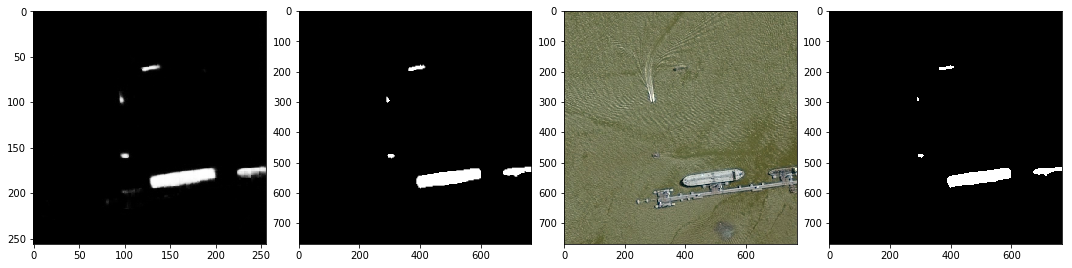

In [31]:
test_sample2(0.5)

In [32]:
#kaggleのページに書いてあった、無視すべき画像
ignore_images = ['13703f040.jpg',
                 '14715c06d.jpg',
                 '33e0ff2d5.jpg',
                 '4d4e09f2a.jpg',
                 '877691df8.jpg',
                 '8b909bb20.jpg',
                 'a8d99130e.jpg',
                 'ad55c3143.jpg',
                 'c8260c541.jpg',
                 'd6c7f17c7.jpg',
                 'dc3e7c901.jpg',
                 'e44dffe88.jpg',
                 'ef87bad36.jpg',
                 'f083256d8.jpg']

めんどいから直してないがtest2のみ動く

In [43]:
"""
テスト画像から、submissionのcsvを作る
"""
def test(th1, th2):
    index = 0
    count1 = 0
    count2 = 0
    df = pd.DataFrame({'ImageId': [], 'EncodedPixels1': [], 'EncodedPixels2': []})
    df = df[['ImageId', 'EncodedPixels1', 'EncodedPixels2']]
    
    for _, (image, image_paths) in enumerate(test_batch):
        image = Variable(image)
        outputs = (model(image).data).cpu().numpy()
        for img_name, out_img in zip(image_paths, outputs):
            if img_name in ignore_images:
                continue
            out_img = out_img.transpose(1,2,0)
            out_img = np.maximum(out_img, 0)
            out_img = np.minimum(out_img, 1)
            out_gray = np.mean(out_img, axis=2)
        
            max_pixel = 1
            _, out_thresh1 = cv2.threshold(out_gray, th1, max_pixel, cv2.THRESH_BINARY)
            _, out_thresh2 = cv2.threshold(out_gray, th2, max_pixel, cv2.THRESH_BINARY)
        
            out_thresh1 = cv2.resize(out_thresh1, (768, 768))
            rl1 = rle_encode(out_thresh1)
            if rl1 != "":
                count1 += 1
            
            out_thresh2 = cv2.resize(out_thresh2, (768, 768))
            rl2 = rle_encode(out_thresh2)
            if rl2 != "":
                count2 += 1
            
            df.loc[index] = [img_name, rl1, rl2]
            if index % 5000 == 0:
                df.to_csv('submission_0804_{}.csv'.format(th1), header=True, index=False, columns=['ImageId', 'EncodedPixels1'])
                df.to_csv('submission_0804_{}.csv'.format(th2), header=True, index=False, columns=['ImageId', 'EncodedPixels2'])

                # 使わない場合は省く
                if index == 0:
                    sn.send_notification(text='{} tests done, th1: {}, th2: {}'.format(index, count1, count2))
                else:
                    sn.send_notification(text='{} tests done, th1: {}, th2: {}'.format(index, count1/index, count2/index))
            index += 1
            
    df.to_csv('submission_0804_{}.csv'.format(th1), header=True, index=False, columns=['ImageId', 'EncodedPixels1'])
    df.to_csv('submission_0804_{}.csv'.format(th2), header=True, index=False, columns=['ImageId', 'EncodedPixels2'])
    # 使わない場合は省く
    sn.send_notification(text='all done')

In [48]:
test(th1=0.5, th2=0.7)

In [33]:
def  approximate_img(_img, eps):
    _, contours, _ = cv2.findContours(_img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    result_img = np.zeros_like(_img)
    for cnt in contours:
        epsilon = eps*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        result_img = cv2.fillConvexPoly(result_img, approx, 1)
    return result_img

def  approximate_img2(_img):
    _, contours, _ = cv2.findContours(_img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    result_img = np.zeros_like(_img)
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        result_img = cv2.fillConvexPoly(result_img, box, 1)
    return result_img

In [37]:
def test2():
    index = 0
    index1 = 0
    index2 = 0
    index3 = 0
    index4 = 0
    df1 = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df1 = df1[['ImageId', 'EncodedPixels']]
    df2 = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df2 = df2[['ImageId', 'EncodedPixels']]
    df3 = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df3 = df3[['ImageId', 'EncodedPixels']]
    df4 = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df4 = df4[['ImageId', 'EncodedPixels']]
    
    for ind, (image, image_paths) in enumerate(test_batch):
        image = Variable(image)
        outputs = (model(image).data).cpu().numpy()
        for img_name, out_img in zip(image_paths, outputs[:,0]):
            if img_name in ignore_images:
                continue
            out_img = np.maximum(out_img, 0)
            out_img = np.minimum(out_img, 1)
        
            max_pixel = 1
            if np.max(out_img) >= 0.8:
                thresh1 = 0.201
                thresh2 = 0.4
            else:
                thresh1 = 0.6
                thresh2 = 0.6
            
            if np.max(out_img) >= 0.5:
                thresh3 = 0.3
            else:
                thresh3 = 0.5
                
            max_pixel = 1
            out_img = cv2.resize(out_img, (768, 768))
                        
            _, out_thresh1 = cv2.threshold(out_img, thresh1, max_pixel, cv2.THRESH_BINARY)
            out_thresh1 = out_thresh1.astype(np.uint8)
            
            rl4 = convert_runlength(out_thresh1)
            df4.loc[index4] = [img_name, rl4]
            index4 += 1
            
            labels_num1, labeled_img1 = cv2.connectedComponents(out_thresh1)
            if labels_num1 <= 1:
                df1.loc[index1] = [img_name, '']
                index1 += 1
            else:
                for j in range(1, labels_num1):
                    separate = np.zeros((768, 768))
                    separate[labeled_img1 == j] = 1
                    rl = convert_runlength(separate)
                    df1.loc[index1] = [img_name, rl]
                    index1 += 1

            _, out_thresh2 = cv2.threshold(out_img, thresh2, max_pixel, cv2.THRESH_BINARY)
            out_thresh2 = np.array(out_thresh2, dtype='uint8')
            labels_num2, labeled_img2 = cv2.connectedComponents(out_thresh2)
            if labels_num2 <= 1:
                df2.loc[index2] = [img_name, '']
                index2 += 1
            else:
                for j in range(1, labels_num2):
                    separate = np.zeros((768, 768))
                    separate[labeled_img2 == j] = 1
                    rl = convert_runlength(separate)
                    df2.loc[index2] = [img_name, rl]
                    index2 += 1

            _, out_thresh3 = cv2.threshold(out_img, thresh3, max_pixel, cv2.THRESH_BINARY)
            out_thresh3 = np.array(out_thresh3, dtype='uint8')
            labels_num3, labeled_img3 = cv2.connectedComponents(out_thresh3)
            
            if labels_num3 <= 1:
                df3.loc[index3] = [img_name, '']
                index3 += 1
            else:
                for j in range(1, labels_num3):
                    separate = np.zeros((768, 768))
                    separate[labeled_img3 == j] = 1
                    rl = convert_runlength(separate)
                    df3.loc[index3] = [img_name, rl]
                    index3 += 1

            
        if ind % 300 == 0:
            df1.to_csv('submission_0930_1.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
            df2.to_csv('submission_0930_2.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
            df3.to_csv('submission_0930_3.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
            df4.to_csv('submission_0930_4.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
            sn.send_notification(text='{} tests done'.format(ind*batch_size))
            
    df1.to_csv('submission_0930_1.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
    df2.to_csv('submission_0930_2.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
    df3.to_csv('submission_0930_3.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
    df4.to_csv('submission_0930_4.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])

    # 使わない場合は省く
    sn.send_notification(text='all done')

In [35]:
def test3():
    index = 0
    index1 = 0
    index2 = 0
    index3 = 0
    df1 = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df1 = df1[['ImageId', 'EncodedPixels']]
    df2 = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df2 = df2[['ImageId', 'EncodedPixels']]
    df3 = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df3 = df3[['ImageId', 'EncodedPixels']]
    
    for ind, (image, image_paths) in enumerate(test_batch):
        image = Variable(image)
        outputs = (model(image).data).cpu().numpy()
        for img_name, out_img in zip(image_paths, outputs):
            if img_name in ignore_images:
                continue
            out_img = out_img.transpose(1,2,0)
            out_img = np.maximum(out_img, 0)
            out_img = np.minimum(out_img, 1)
            out_gray = np.mean(out_img, axis=2)
        
            max_pixel = 1
            if np.max(out_gray) >= 0.7:
                thresh1 = 0.201
                thresh2 = 0.3
            else:
                thresh1 = 0.6
                thresh2 = 0.6
            
            if np.max(out_gray) >= 0.5:
                thresh3 = 0.2
            else:
                thresh3 = 0.5
                
            max_pixel = 1
            out_gray = cv2.resize(out_gray, (768, 768))
                        
            _, out_thresh1 = cv2.threshold(out_gray, thresh1, max_pixel, cv2.THRESH_BINARY)
            rl1 = convert_runlength(out_thresh1)
            df1.loc[index] = [img_name, rl1]

            _, out_thresh2 = cv2.threshold(out_gray, thresh2, max_pixel, cv2.THRESH_BINARY)
            rl2 = convert_runlength(out_thresh2)
            df2.loc[index] = [img_name, rl2]

            _, out_thresh3 = cv2.threshold(out_gray, thresh3, max_pixel, cv2.THRESH_BINARY)
            rl3 = convert_runlength(out_thresh3)
            df3.loc[index] = [img_name, rl3]
            
            index += 1

            
        if ind % 300 == 0:
            df1.to_csv('submission_0816_1.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
            df2.to_csv('submission_0816_2.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
            df3.to_csv('submission_0816_3.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
            sn.send_notification(text='{} tests done'.format(ind*batch_size))
            
    df1.to_csv('submission_0816_1.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
    df2.to_csv('submission_0816_2.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
    df3.to_csv('submission_0816_3.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels'])
    # 使わない場合は省く
    sn.send_notification(text='all done')

In [38]:
test2()

# Re-training

学習済みモデルをさらに学習させる

In [13]:
recon_loss_func = nn.L1Loss()
generator = Unet34()
generator.load_state_dict(torch.load("./model_unet34/unet_7_200_state.pkl"))
lr = 0.0005
gen_optimizer = torch.optim.Adam(generator.parameters(),lr=lr)

In [ ]:
test(10, 'unet34_retrain')